In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [ ]:
%load_ext autoreload
%autoreload 2

## Create DATASET

### 1 - Generate mask instances

In [ ]:
from data_utils import generate_annotations_json

In [ ]:
dataset_path = '/root/data/erko/'
mask_dir = 'instance_labels'
frame_dir = 'labeled_frames'
dataset_name = 'fish_only'
class_ID_path = '/root/data/erko/class_ID.csv'

In [ ]:
#d_train, d_test = generate_annotations_json(dataset_path=dataset_path,
#                          mask_dir=mask_dir,
#                          frame_dir=frame_dir,
#                          dataset_name=dataset_name,
#                          class_ID_path=class_ID_path,
#                        )

### 2 - Create folder structure

In [ ]:
from data_utils import create_training_folder_structure

In [ ]:
train_json = 'instance_fish_only_train.json'
test_json = 'instance_fish_only_test.json'
train_target_dir = 'instance_train_images'
test_target_dir = 'instance_test_images'


In [ ]:
#create_training_folder_structure(dataset_path=dataset_path,
#                                 train_json=train_json,
#                                 test_json=test_json,
#                                 train_target_dir=train_target_dir,
#                                 test_target_dir=test_target_dir, 
#                                 frame_dir=frame_dir)

### 3 - Datasets

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import keras

sys.path.insert(0, '../libraries')
from mrcnn.config import Config
import mrcnn.utils as utils
import mrcnn.model as modellib
import mrcnn.visualize as visualize
from mrcnn.model import log
import mcoco.coco as coco
# import mextra.utils as extra_utils
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline
%config IPCompleter.greedy=True
BASE_DIR = '/root/data/models/erko/mask_rcnn_instance_segmentation'
DATA_DIR = '/root/data/erko/'
WEIGHTS_DIR = os.path.join(BASE_DIR, "weights")
MODEL_DIR = os.path.join(BASE_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size ch

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
# train dataset
dataset_train  = coco.CocoDataset()
dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_lateral_2018-09-19.json', class_ids=[0])
dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_lateral_2018-09-08.json', class_ids=[0])
dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_lateral_2018-09-10.json', class_ids=[0])
dataset_train.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_lateral_2018-09-11.json', class_ids=[0])
dataset_train.prepare()
print("Number of train images: {}".format(dataset_train.num_images))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of train images: 1528
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Number of train images: 1528


In [5]:
# val dataset
dataset_validate  = coco.CocoDataset()
dataset_validate.load_coco('/root/data/aquabyte-images/cocofiles/coco_clear_full_lateral_2018-09-07.json', class_ids=[0])
dataset_validate.prepare()
print("Number of validation images: {}".format(dataset_validate.num_images))

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of validation images: 456
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Number of validation images: 456


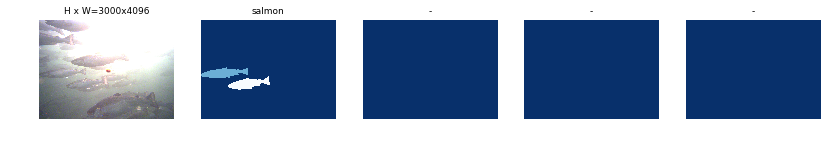

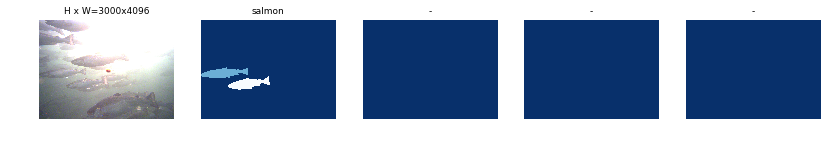

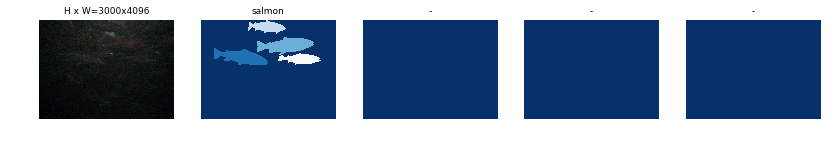

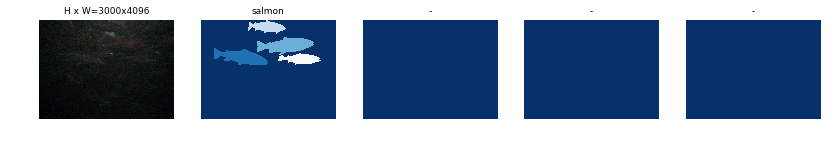

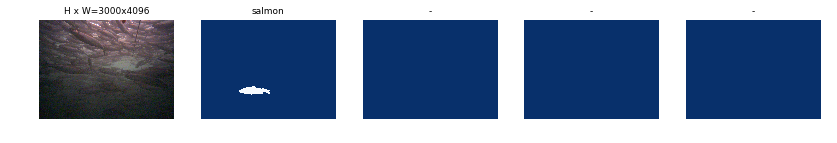

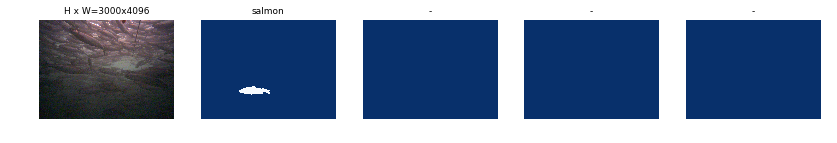

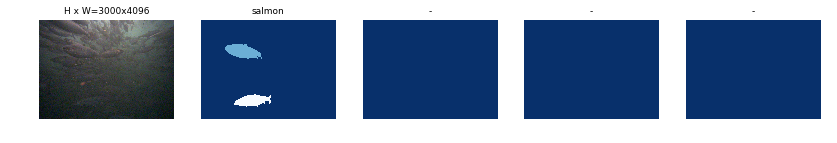

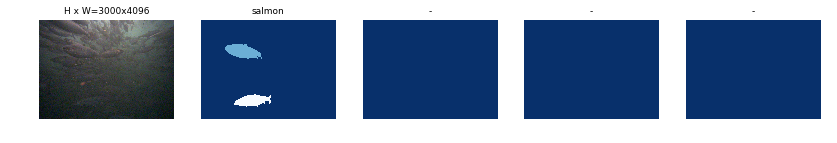

In [6]:
# Load and display random samples# Load  
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Configuration

In [7]:
image_size = 512
rpn_anchor_template = (1, 2, 4, 8, 16) # anchor sizes in pixels
rpn_anchor_scales = tuple(i * (image_size // 16) for i in rpn_anchor_template)

class FishConfig(Config):
    """Configuration for training on the shapes dataset.
    """
    # name your experiments here
    NAME = "clear_full_lateral"

    # Train on 1 GPU and 2 images per GPU. Put multiple images on each
    # GPU if the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes (triangles, circles, and squares)

    # Use smaller images for faster training. 
    IMAGE_MAX_DIM = image_size
    IMAGE_MIN_DIM = image_size
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = rpn_anchor_scales

    # Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 300
    
config = FishConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MI

## Model

In [8]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [9]:
inititalize_weights_with = "coco"  # imagenet, coco, or last

if inititalize_weights_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
    
elif inititalize_weights_with == "coco":
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
    
elif inititalize_weights_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## Training

In [10]:
# add more callbacks here if necessary
callbacks = [
    keras.callbacks.TensorBoard(log_dir=model.log_dir,
                                histogram_freq=0, write_graph=True, write_images=False),
    keras.callbacks.ModelCheckpoint(model.checkpoint_path,
                                    verbose=0, save_weights_only=True),
]

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [ ]:
model.train(dataset_train, dataset_validate, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=100, # starts from the previous epoch, so only 1 additional is trained 
            layers="all",
            callback_list=callbacks)


Starting at epoch 0. LR=0.0001

Checkpoint Path: /root/data/models/erko/mask_rcnn_instance_segmentation/logs/clear_full_lateral_20181002_19H09/mask_rcnn_clear_full_lateral_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a    


Starting at epoch 0. LR=0.0001

Checkpoint Path: /root/data/models/erko/mask_rcnn_instance_segmentation/logs/clear_full_lateral_20181002_19H09/mask_rcnn_clear_full_lateral_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a    

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.5/dist-packages/keras/engine/training_generator.py:46: UserWarning: Using a generator with `use_multiprocess

Epoch 1/100
Epoch 1/100
1000/1000 [==============================] - 549s 549ms/step - loss: 0.9835 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.1629 - mrcnn_class_loss: 0.2142 - mrcnn_bbox_loss: 0.2799 - mrcnn_mask_loss: 0.3122 - val_loss: 0.7124 - val_rpn_class_loss: 0.0161 - val_rpn_bbox_loss: 0.1606 - val_mrcnn_class_loss: 0.1703 - val_mrcnn_bbox_loss: 0.1550 - val_mrcnn_mask_loss: 0.2105
Epoch 2/100
1000/1000 [==============================] - 501s 501ms/step - loss: 0.5834 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.1355 - mrcnn_bbox_loss: 0.1280 - mrcnn_mask_loss: 0.2114 - val_loss: 0.6410 - val_rpn_class_loss: 0.0122 - val_rpn_bbox_loss: 0.1121 - val_mrcnn_class_loss: 0.1709 - val_mrcnn_bbox_loss: 0.1357 - val_mrcnn_mask_loss: 0.2102
Epoch 3/100
Epoch 3/100
1000/1000 [==============================] - 503s 503ms/step - loss: 0.5272 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.1307 - mrcnn_bbox_loss: 0.1080 - mrcnn_mask_loss: 0

## Detection

### 1 - Inference config

In [ ]:
class InferenceConfig(FishConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
print(model.find_last()[1])
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

### Test on random image from test set

In [ ]:
image_id = random.choice(dataset_validate.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_validate, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_validate.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_validate.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
predictions =\
extra_utils.compute_multiple_per_class_precision(model, inference_config, dataset_validate, iou_threshold=0.5)
complete_predictions = []

for shape in predictions:
    complete_predictions += predictions[shape]
    print("{} ({}): {}".format(shape, len(predictions[shape]), np.mean(predictions[shape])))

print("--------")
print("average: {}".format(np.mean(complete_predictions)))

## Testing

In [ ]:
image_ids = dataset_validate.image_ids

In [ ]:
image_id = image_ids[0]

In [ ]:
image_id

In [ ]:
image, _, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_validate, inference_config,
                                image_id, use_mini_mask=False)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(image)

In [ ]:
plt.imshow(gt_mask[..., 0])

In [ ]:
results = model.detect([image], verbose=0)

In [ ]:
plt.imshow(results[0]['masks'][..., 2])